In [2]:
#Importing libraries
import pandas as pd
import numpy as np
from scipy.optimize import fmin_slsqp
import os
import matplotlib.pyplot as plt
#import seaborn as sns
from pprint import pprint
import random

#Listing the existing files in the dir
# for root, dirs, files in os.walk("."):  
#     for filename in files:
#         print(filename)

In [2]:
#Loading df
df = pd.read_csv('./files/data-2018-09-24.csv')
df = df.drop(df.loc[:,['name', 'pft']].head(0).columns, axis=1)
inpt_df = df.iloc[:, 1:6]
inpt_arr = np.array(inpt_df)
outpt_df = df.iloc[:, 6:]
outpt_arr = np.array(outpt_df)
comp = np.array(df.iloc[:, 0])

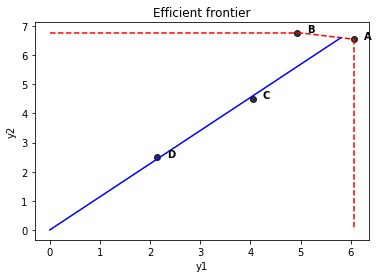

In [7]:
#For the article
inputs = pd.DataFrame(inpt_df.iloc[:4,4])
outputs = outpt_df.iloc[:4,0:2]
l = []
for col in inputs.columns:
    l.append(outputs.div(inputs[col], axis=0))
complete = pd.concat(l, axis=1)
complete.columns = ['y1', 'y2']
completed = pd.DataFrame(df.iloc[:4, 0]).join(complete)

#Plotting the graph
p1 = sns.regplot(data = completed, x="y1", y="y2", fit_reg = False, marker="o", color = 'black')
 
# add annotations one by one with a loop
for line in range(0,completed.shape[0]):
     p1.text(completed.y1[line]+0.2, completed.y2[line], completed.firm[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

p1.set_title('Efficient frontier')

plt.plot([0, 4.938],[6.778,6.778], "r--")
plt.plot([4.938, 6.058889],[6.778, 6.553333], "r--")
plt.plot([6.058889, 6.058889],[6.553333, 0], "r--")
plt.plot([0,5.8],[0,6.6] , "b")

In [8]:
#Loading df
df2 = pd.read_csv('StrikerPerformance.csv') #skiprows = 1)
df2 = df2.drop(df2.loc[:,['age', 'current club', 'current league', 'foot', 'height', 'nationality', 'position']].head(0).columns, axis=1)
df2.head() #where xs are input vars and ys are output vars

,assists,games,goals,minutes,name
0,15,39,12,2774,Leroy Sané
1,10,36,20,2774,Raheem Sterling
2,11,44,7,2329,Bernardo Silva
3,7,37,30,2895,Sergio Agüero
4,4,31,11,1766,Gabriel Jesus


In [11]:
# df2 = pd.read_csv('StrikerPerformance.csv')
inputss = pd.DataFrame(df2.iloc[:,[1,3]])
outputss = pd.DataFrame(df2.iloc[:,[0,2]])
comp_2 = np.array(df2.iloc[:, 4])
inpt_arr_2 = np.array(inputss)
outpt_arr_2 = np.array(outputss)
l = range(inpt_arr_2.shape[1])
np.zeros((inpt_arr_2.shape[1],1), dtype=np.float)

array([[0.],
       [0.]])

In [12]:
# inpt_arr_2 = np.array(inputss)
# outpt_arr_2 = np.array(outputss)

class DEA(object):
    random.seed(5)
    def __init__(self, inputs, outputs):
        """
        Initialize the DEA object with input data
        n = number of entities (observations)
        m = number of inputs (variables, features)
        r = number of outputs
        :param inputs: inputs, n x m numpy array
        :param outputs: outputs, n x r numpy array
        :return: self
        """

        # supplied data
        self.inputs = inputs
        self.outputs = outputs

        # parameters
        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]

        # iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)

        # result arrays
        self.output_w = np.zeros((self.r, 1), dtype=np.float)  # output weights
        self.input_w = np.zeros((self.m, 1), dtype=np.float)  # input weights
        self.lambdas = np.zeros((self.n, 1), dtype=np.float)  # unit efficiencies
        self.efficiency = np.zeros_like(self.lambdas)  # thetas

        # names
        self.names = []

    def __efficiency(self, unit):
        """
        Efficiency function with already computed weights
        :param unit: which unit to compute for
        :return: efficiency
        """

        # compute efficiency
        denominator = np.dot(self.inputs, self.input_w)
        numerator = np.dot(self.outputs, self.output_w)

        return (numerator/denominator)[unit]

    def __target(self, x, unit):
        """
        Theta target function for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: theta
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        denominator = np.dot(self.inputs[unit], in_w)
        numerator = np.dot(self.outputs[unit], out_w)

        return numerator/denominator

    def __constraints(self, x, unit):
        """
        Constraints for optimization for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: array of constraints
        """

        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        constr = []  # init the constraint array

        # for each input, lambdas with inputs
        for input in self.input_:
            t = self.__target(x, unit)
            lhs = np.dot(self.inputs[:, input], lambdas)
            cons = t*self.inputs[unit, input] - lhs
            constr.append(cons)

        # for each output, lambdas with outputs
        for output in self.output_:
            lhs = np.dot(self.outputs[:, output], lambdas)
            cons = lhs - self.outputs[unit, output]
            constr.append(cons)

        # for each unit
        for u in self.unit_:
            constr.append(lambdas[u])

        return np.array(constr)

    def __optimize(self):
        """
        Optimization of the DEA model
        Use: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.linprog.html
        A = coefficients in the constraints
        b = rhs of constraints
        c = coefficients of the target function
        :return:
        """
        d0 = self.m + self.r + self.n
        # iterate over units
        for unit in self.unit_:
            # weights
            x0 = np.random.rand(d0) - 0.5
            x0 = fmin_slsqp(self.__target, x0, f_ieqcons=self.__constraints, args=(unit,))
            # unroll weights
            self.input_w, self.output_w, self.lambdas = x0[:self.m], x0[self.m:(self.m+self.r)], x0[(self.m+self.r):]
            self.efficiency[unit] = self.__efficiency(unit)

    def name_units(self, names):
        """
        Provide names for units for presentation purposes
        :param names: a list of names, equal in length to the number of units
        :return: nothing
        """

        assert(self.n == len(names))

        self.names = names

    def fit(self):
        """
        Optimize the dataset, generate basic table
        :return: table
        """

        self.__optimize()  # optimize
        print("---------------------------\n")       

        m = {}
        l = {}         
        for n, eff in enumerate(self.efficiency):           
            if eff >= 1.:
                m.update({self.names[n]: eff[0]}) 
            else:
                l.update({self.names[n]: eff[0]})                 
        print("Efficient units:")     
        print(str(m).replace("{","").replace("}", ""))       
        print("\n")    
        print("Inefficient units:")
        print(str(l).replace("{","").replace("}", ""))  
        for n in enumerate(self.efficiency):
            print(self.input_w, self.output_w)
        


dea = DEA(inpt_arr_2, outpt_arr_2)
dea.name_units(comp_2)
dea.fit()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000000436755
            Iterations: 17
            Function evaluations: 2264
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8860157504907372
            Iterations: 14
            Function evaluations: 1849
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5900071914830856
            Iterations: 6
            Function evaluations: 802
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.990629679735921
            Iterations: 15
            Function evaluations: 1979
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6185686543520579
            Iterations: 9
            Func

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.81828577396445
            Iterations: 9
            Function evaluations: 1193
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.23049124135648472
            Iterations: 14
            Function evaluations: 1860
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6206030540367182
            Iterations: 13
            Function evaluations: 1710
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4.2666053255789286e-05
            Iterations: 30
            Function evaluations: 3480
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.20812101894422477
            Iterations: 12
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.29293809860066944
            Iterations: 13
            Function evaluations: 1729
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4944063001361981
            Iterations: 7
            Function evaluations: 942
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.464699037349193
            Iterations: 6
            Function evaluations: 804
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3221144333565683
            Iterations: 13
            Function evaluations: 1589
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3008206493529987
            Iterations: 14
            Funct

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2963212825757345
            Iterations: 13
            Function evaluations: 1717
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.07352806951116084
            Iterations: 9
            Function evaluations: 1192
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.22799767567824783
            Iterations: 10
            Function evaluations: 1327
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.14309778625276393
            Iterations: 15
            Function evaluations: 1862
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4600439865400728
            Iterations: 12
          

In [36]:
#Calculating DEA
class DEA(object):

    def __init__(self, inputs, outputs):
        """
        Initialize the DEA object with input data
        n = number of entities (observations)
        m = number of inputs (variables, features)
        r = number of outputs
        :param inputs: inputs, n x m numpy array
        :param outputs: outputs, n x r numpy array
        :return: self
        """

        # supplied data
        self.inputs = inputs
        self.outputs = outputs

        # parameters
        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]

        # iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)

        # result arrays
        self.output_w = np.zeros((self.r, 1), dtype=np.float)  # output weights
        self.input_w = np.zeros((self.m, 1), dtype=np.float)  # input weights
        self.lambdas = np.zeros((self.n, 1), dtype=np.float)  # unit efficiencies
        self.efficiency = np.zeros_like(self.lambdas)  # thetas

        # names
        self.names = []

    def __efficiency(self, unit):
        """
        Efficiency function with already computed weights
        :param unit: which unit to compute for
        :return: efficiency
        """

        # compute efficiency
        denominator = np.dot(self.inputs, self.input_w)
        numerator = np.dot(self.outputs, self.output_w)

        return (numerator/denominator)[unit]

    def __target(self, x, unit):
        """
        Theta target function for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: theta
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        denominator = np.dot(self.inputs[unit], in_w)
        numerator = np.dot(self.outputs[unit], out_w)

        return numerator/denominator

    def __constraints(self, x, unit):
        """
        Constraints for optimization for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: array of constraints
        """

        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        constr = []  # init the constraint array

        # for each input, lambdas with inputs
        for input in self.input_:
            t = self.__target(x, unit)
            lhs = np.dot(self.inputs[:, input], lambdas)
            cons = t*self.inputs[unit, input] - lhs
            constr.append(cons)

        # for each output, lambdas with outputs
        for output in self.output_:
            lhs = np.dot(self.outputs[:, output], lambdas)
            cons = lhs - self.outputs[unit, output]
            constr.append(cons)

        # for each unit
        for u in self.unit_:
            constr.append(lambdas[u])

        return np.array(constr)

    def __optimize(self):
        """
        Optimization of the DEA model
        Use: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.linprog.html
        A = coefficients in the constraints
        b = rhs of constraints
        c = coefficients of the target function
        :return:
        """
        d0 = self.m + self.r + self.n
        # iterate over units
        for unit in self.unit_:
            # weights
            x0 = np.random.rand(d0) - 0.5
            x0 = fmin_slsqp(self.__target, x0, f_ieqcons=self.__constraints, args=(unit,))
            # unroll weights
            self.input_w, self.output_w, self.lambdas = x0[:self.m], x0[self.m:(self.m+self.r)], x0[(self.m+self.r):]
            self.efficiency[unit] = self.__efficiency(unit)

    def name_units(self, names):
        """
        Provide names for units for presentation purposes
        :param names: a list of names, equal in length to the number of units
        :return: nothing
        """

        assert(self.n == len(names))

        self.names = names

    def fit(self):
        """
        Optimize the dataset, generate basic table
        :return: table
        """

        self.__optimize()  # optimize
        print("---------------------------\n")       

        m = {}
        l = {}         
        for n, eff in enumerate(self.efficiency):           
            if eff >= 1.:
                m.update({self.names[n]: eff[0]}) 
            else:
                l.update({self.names[n]: eff[0]})                 
        print("Efficient units:")     
        print(str(m).replace("{","").replace("}", ""))       
        print("\n")    
        print("Inefficient units:")
        print(str(l).replace("{","").replace("}", ""))         
            

dea = DEA(inpt_arr,outpt_arr)
dea.name_units(comp)
dea.fit()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.00000003588
            Iterations: 18
            Function evaluations: 650
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.966316603098
            Iterations: 14
            Function evaluations: 504
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.99581214551
            Iterations: 20
            Function evaluations: 722
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.932140293891
            Iterations: 15
            Function evaluations: 540
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.00000000444
            Iterations: 8
            Function evaluations: 288
 

In [22]:
#Calculation efficiency by dividing output by input to be used for the graph
frst = outpt_df.div(inpt_df.x1, axis = 0)
frst.columns = ['y1-x1', 'y2-x1', 'y3-x1']
sec = outpt_df.div(inpt_df.x2, axis = 0)
sec.columns = ['y1-x2', 'y2-x2', 'y3-x2']
th = outpt_df.div(inpt_df.x3, axis = 0)
th.columns = ['y1-x3', 'y2-x3', 'y3-x3']
fo = outpt_df.div(inpt_df.x4, axis = 0)
fo.columns = ['y1-x4', 'y2-x4', 'y3-x4']
fi = outpt_df.div(inpt_df.x5, axis = 0)
fi.columns = ['y1-x5', 'y2-x5', 'y3-x5']
complete = pd.DataFrame(df.iloc[:,0]).join(frst).join(sec).join(th).join(fo).join(fi)

In [ ]:
#Building a graph
eff = ['y1-x1', 'y2-x1', 'y3-x1', 'y1-x2', 'y2-x2', 'y3-x2',
       'y1-x3', 'y2-x3', 'y3-x3', 'y1-x4', 'y2-x4', 'y3-x4', 'y1-x5',
       'y2-x5', 'y3-x5']
x = [i for i, _ in enumerate(eff)]

min_max_range = {}
for e in eff:
    min_max_range[e] = [complete[e].min(), complete[e].max(), np.ptp(complete[e])]
    complete[e] = np.true_divide(complete[e] - complete[e].min(), np.ptp(complete[e]))
    
fig, axes = plt.subplots(1, len(x)-1, sharey = False, figsize = (50,10), gridspec_kw = {'wspace':0, 'hspace':0})    

# Plot each row
for i, ax in enumerate(axes):
    for idx in complete.index:
        ax.plot(x, complete.loc[idx, eff], color='gray')  
    ax.set_xlim([x[i], x[i+1]])

plt.title("Efficiency by a firm")
plt.show()

In [97]:
firms = ['1', '2', '3']
df = pd.DataFrame(firms)
output = { 'firms': ['1', '2', '3'],
'Sales': [150, 200, 50],
'Profit':[200, 210, 90],
'Sth':[1, 2, 3]}
df1 = pd.DataFrame.from_dict(output)
inputs = { 'firms': ['1', '2', '3'],
'Salary': [10000, 20000, 500],
'employees':[2, 4, 5]}
df2 = pd.DataFrame.from_dict(inputs)

In [ ]:
complete.to_csv('./files/output.csv')